In [1]:
# Player position and 'similar premier league players' Classifier

# Kmeans clustering algorithm to cluster premier league players into different groups to predict position
# Then can place any player outside the prem (e.g. Haaland) into system and see what players are most similar using
# simple knn algorithm.

# 1. Trim data of any useless variables
# 2. Get players that are represenative (min. minutes)
# 3. Find most useful variables
# 4. Standardize variables
# 5. Use k-means to cluster players based on playstyle 
#   - k=5 (centre back, fullback, box-to-box mid, creative forward, forward)
# 6. Predict new player's positions from other leagues 
# 7. Use simple knn to find 5 nearest styled players from the premier league
# 8. Display graphically



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("2021-2022_Football_Player_Stats.csv", sep = ';', encoding = 'ISO-8859-1')
df.head()
df.describe()

,ï»¿Rk,Age,Born,MP,Starts,Min,90s,Goals,Shots,SoT,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
count,2921.000000,2920.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,...,2921.000000,2921.000000,2921.000000,2921.00000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000
mean,1461.000000,26.092123,1994.725094,18.800068,13.749743,1234.756248,13.719069,0.111274,1.220431,0.391462,...,0.195029,1.063708,1.026689,0.01519,0.013050,0.003451,7.410294,1.664286,1.858305,40.485861
std,843.364393,4.641746,37.210426,11.619882,11.393763,977.941288,10.865255,0.233688,1.511266,0.784754,...,0.509935,1.341177,1.028466,0.21167,0.052864,0.020306,3.650554,1.938046,2.245096,24.297290
min,1.000000,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,731.000000,23.000000,1992.000000,8.000000,3.000000,307.000000,3.400000,0.000000,0.280000,0.000000,...,0.000000,0.000000,0.430000,0.00000,0.000000,0.000000,5.070000,0.520000,0.840000,26.200000
50%,1461.000000,26.000000,1996.000000,20.000000,12.000000,1102.000000,12.200000,0.000000,0.820000,0.190000,...,0.000000,0.590000,0.920000,0.00000,0.000000,0.000000,7.380000,1.230000,1.390000,43.500000
75%,2191.000000,29.000000,1999.000000,29.000000,23.000000,2025.000000,22.500000,0.150000,1.830000,0.560000,...,0.200000,1.700000,1.410000,0.00000,0.000000,0.000000,9.380000,2.270000,2.210000,57.100000
max,2921.000000,41.000000,2006.000000,38.000000,38.000000,3420.000000,38.000000,5.000000,20.000000,20.000000,...,10.000000,15.000000,10.000000,10.00000,1.430000,0.500000,40.000000,30.000000,40.000000,100.000000


In [4]:
prem_data = df[df['Comp']=='Premier League']
prem_data.head()

,ï»¿Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22.0,2000,34,32,...,0.03,1.41,1.16,0.00,0.06,0.03,5.53,0.47,1.59,22.7
13,14,Che Adams,SCO,FW,Southampton,Premier League,25.0,1996,30,23,...,0.31,0.48,0.40,0.00,0.00,0.00,5.29,2.47,4.89,33.5
34,35,Rayan AÃt Nouri,FRA,DF,Wolves,Premier League,20.0,2001,23,20,...,0.15,2.76,2.12,0.05,0.00,0.00,6.65,0.99,0.94,51.3
35,36,Kristoffer Ajer,NOR,DF,Brentford,Premier League,24.0,1998,24,23,...,0.00,0.54,0.99,0.00,0.00,0.00,8.38,2.84,1.71,62.4
40,41,Nathan AkÃ,NED,DF,Manchester City,Premier League,27.0,1995,14,10,...,0.00,0.00,0.49,0.00,0.00,0.00,7.57,3.98,0.78,83.7


In [5]:
prem_data.describe()

,ï»¿Rk,Age,Born,MP,Starts,Min,90s,Goals,Shots,SoT,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,...,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,1493.864469,26.320513,1995.139194,19.203297,15.311355,1375.664835,15.283883,0.110513,1.233388,0.365293,...,0.145531,1.035403,1.003718,0.025751,0.010220,0.003828,7.470073,1.561832,1.954597,40.324176
std,843.736528,4.381134,4.374535,11.617168,11.609793,1012.718652,11.251539,0.190356,1.491153,0.594971,...,0.256909,1.273586,0.944158,0.428697,0.029713,0.023395,3.239207,1.482670,2.623878,23.663398
min,1.000000,17.000000,1981.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,785.750000,23.000000,1992.000000,9.000000,4.000000,398.000000,4.425000,0.000000,0.312500,0.000000,...,0.000000,0.030000,0.482500,0.000000,0.000000,0.000000,5.307500,0.550000,0.932500,25.100000
50%,1460.500000,26.000000,1995.000000,20.000000,15.000000,1328.000000,14.750000,0.030000,0.815000,0.195000,...,0.000000,0.615000,0.910000,0.000000,0.000000,0.000000,7.590000,1.165000,1.365000,43.300000
75%,2274.500000,29.750000,1998.000000,29.750000,25.000000,2154.000000,23.950000,0.150000,1.880000,0.560000,...,0.177500,1.655000,1.365000,0.000000,0.000000,0.000000,9.577500,2.267500,2.085000,58.300000
max,2919.000000,40.000000,2004.000000,38.000000,38.000000,3420.000000,38.000000,2.000000,20.000000,10.000000,...,1.450000,10.000000,10.000000,10.000000,0.230000,0.420000,30.000000,13.300000,30.000000,100.000000


In [6]:
prem_data.dtypes


ï»¿Rk        int64
Player      object
Nation      object
Pos         object
Squad       object
            ...   
OG         float64
Recov      float64
AerWon     float64
AerLost    float64
AerWon%    float64
Length: 143, dtype: object

In [7]:
#Data preperation
prem_data['Pos'].unique()

array(['DF', 'FW', 'FWDF', 'MF', 'GK', 'MFFW', 'FWMF', 'DFMF', 'MFDF',
       'DFFW'], dtype=object)

In [8]:
# Key to getting representaive statistics of players using only those with minimum 500 minutes
prem_data = prem_data[prem_data['Min']>500]

In [9]:
#remove goalkeepers
prem_data = prem_data[prem_data['Pos']!='GK']
# trim non-performance variables
trimmed_data = prem_data.drop(['ï»¿Rk','Player','Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s'],axis=1)
trimmed_data.head(100)

,Goals,Shots,SoT,SoT%,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,0.00,0.41,0.06,15.4,0.00,0.00,20.5,0.00,0.0,0.0,...,0.03,1.41,1.16,0.00,0.06,0.03,5.53,0.47,1.59,22.7
13,0.31,2.16,1.06,49.0,0.14,0.29,12.9,0.00,0.0,0.0,...,0.31,0.48,0.40,0.00,0.00,0.00,5.29,2.47,4.89,33.5
34,0.05,0.64,0.20,30.8,0.08,0.25,16.9,0.00,0.0,0.0,...,0.15,2.76,2.12,0.05,0.00,0.00,6.65,0.99,0.94,51.3
35,0.05,0.32,0.05,14.3,0.14,1.00,9.1,0.00,0.0,0.0,...,0.00,0.54,0.99,0.00,0.00,0.00,8.38,2.84,1.71,62.4
40,0.19,0.49,0.19,40.0,0.40,1.00,5.8,0.00,0.0,0.0,...,0.00,0.00,0.49,0.00,0.00,0.00,7.57,3.98,0.78,83.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,0.15,1.56,0.52,33.3,0.10,0.29,15.4,0.00,0.0,0.0,...,0.22,1.19,1.26,0.00,0.00,0.00,4.96,2.00,1.85,51.9
814,0.00,0.89,0.22,25.0,0.00,0.00,25.7,0.00,0.0,0.0,...,0.00,0.00,1.00,0.00,0.00,0.00,10.40,1.22,1.22,50.0
818,0.18,1.89,0.75,39.5,0.09,0.24,13.7,0.00,0.0,0.0,...,0.04,1.54,1.45,0.00,0.00,0.00,7.36,1.54,2.69,36.5
821,0.04,0.59,0.16,26.7,0.07,0.25,14.6,0.00,0.0,0.0,...,0.08,2.36,1.54,0.00,0.00,0.00,8.31,1.61,1.65,49.4


In [10]:
# Most correlated variables
corrmat = trimmed_data.corr()
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))
corr_list = upper_tri.stack().sort_values(ascending=False)
print(corr_list.head(50))


PasTotCmp   PasCmp         1.000000
PasTotAtt   PasAtt         1.000000
PasCrs      Crs            1.000000
TklWon      TklW           1.000000
DriSucc     DriPast        0.994232
PasMedCmp   PasMedAtt      0.993626
PasShoCmp   PasShoAtt      0.993440
PasAtt      Touches        0.991199
PasTotAtt   Touches        0.991199
PasLive     TouLive        0.989702
PasTotCmp   PasLive        0.988949
PasLive     PasCmp         0.988949
PasAtt      PasCmp         0.984774
PasTotAtt   PasCmp         0.984774
PasTotCmp   PasAtt         0.984774
            PasTotAtt      0.984774
PasTotDist  PasMedCmp      0.979564
PasLive     PasGround      0.978188
PasTotDist  PasMedAtt      0.977035
PasAtt      PasLive        0.976410
PasTotAtt   PasLive        0.976410
PasGround   PasCmp         0.976239
PasTotCmp   PasGround      0.976239
            TouLive        0.974831
PasCmp      TouLive        0.974831
Touches     TouLive        0.974757
PasTotCmp   Touches        0.972326
PasCmp      Touches        0

In [11]:
# Drop any columns that have very high correlation with others 
# (Have no effect on model due to repeat data so drop to help dimensionality)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); 
print(to_drop)
trimmed_data = trimmed_data.drop(to_drop,axis=1)


['PKatt', 'PasTotAtt', 'PasTotDist', 'PasShoAtt', 'PasMedCmp', 'PasMedAtt', 'PasAtt', 'PasLive', 'PasGround', 'PasCmp', 'Touches', 'TouLive', 'DriPast', 'CarPrgDist', 'Rec', 'Crs', 'TklW']


114


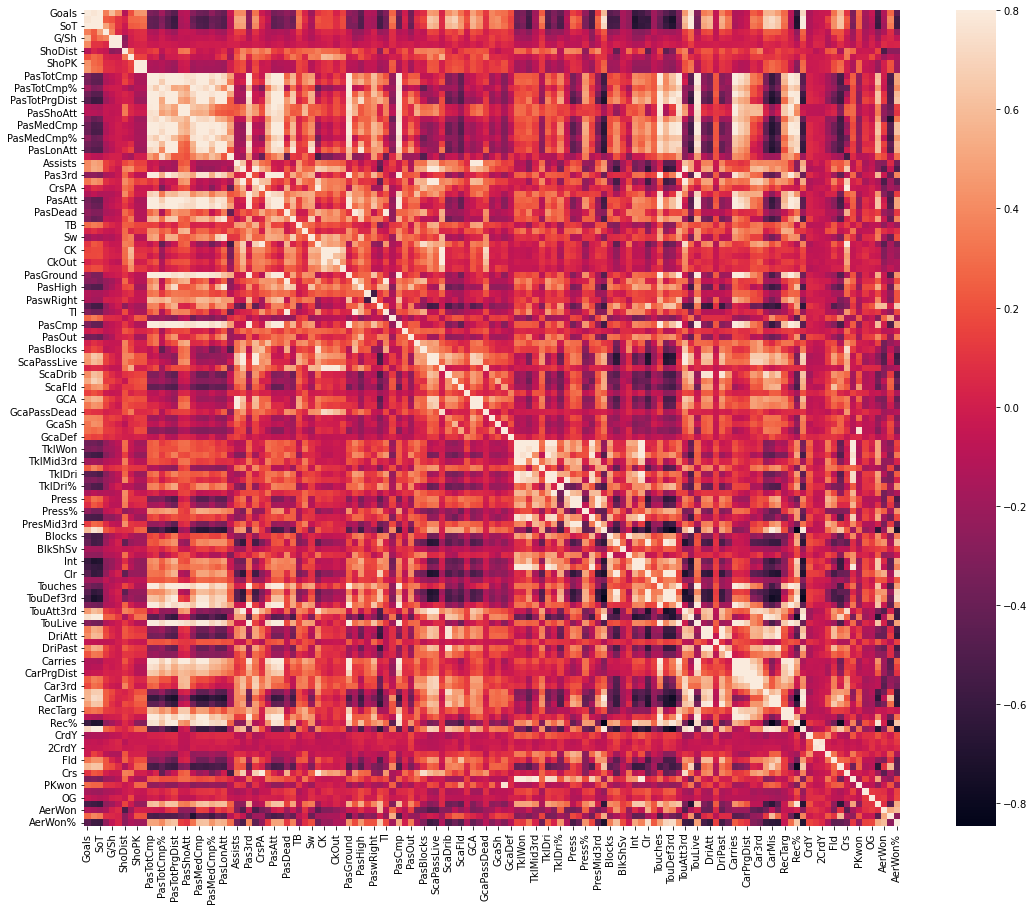

In [12]:
#Correlation Matrix in full
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True);
print(len(trimmed_data.columns))

In [13]:
#normalise data to make variables equal weighting
scaler = MinMaxScaler()
model = scaler.fit(trimmed_data)
trimmed_data = model.transform(trimmed_data)

#create kmeans model 
kmeans = KMeans(init='random', n_clusters=5, n_init=100, random_state=0)
#fit and predict
y = kmeans.fit_predict(trimmed_data)
for i in range(5):
    print(prem_data[y==i].head(50))
    print('------------------------------------------------------------------')

# At this point I analyzed the clusters and labeled the clusters after the position that the majority of them played
mapping = {0: 'Box-to-Box', 1:'Fullback', 2:'Creative forwards', 3:'Centre back', 4:'Striker'}
y_hue = [mapping[i] for i in y]

      ï»¿Rk                 Player Nation   Pos            Squad  \
56       57      Thiago AlcÂ·ntara    ESP    MF        Liverpool   
66       67                  Allan    BRA    MF          Everton   
69       70              Dele Alli    ENG  MFFW        Tottenham   
281     282      Rodrigo Bentancur    URU    MF        Tottenham   
318     319          Yves Bissouma    MLI    MF         Brighton   
382     383         Josh Brownhill    ENG    MF          Burnley   
423     424        MoisÃs Caicedo    ECU    MF         Brighton   
545     546          Tom Cleverley    ENG    MF          Watford   
570     571              Jack Cork    ENG    MF          Burnley   
667     668           Fabian Delph    ENG    MF          Everton   
676     677     Leander Dendoncker    BEL    MF           Wolves   
686     687  Kiernan Dewsbury Hall    ENG    MF   Leicester City   
701     702        Ibrahima Diallo    FRA    MF      Southampton   
763     764    Abdoulaye DoucourÃ    MLI    MF 

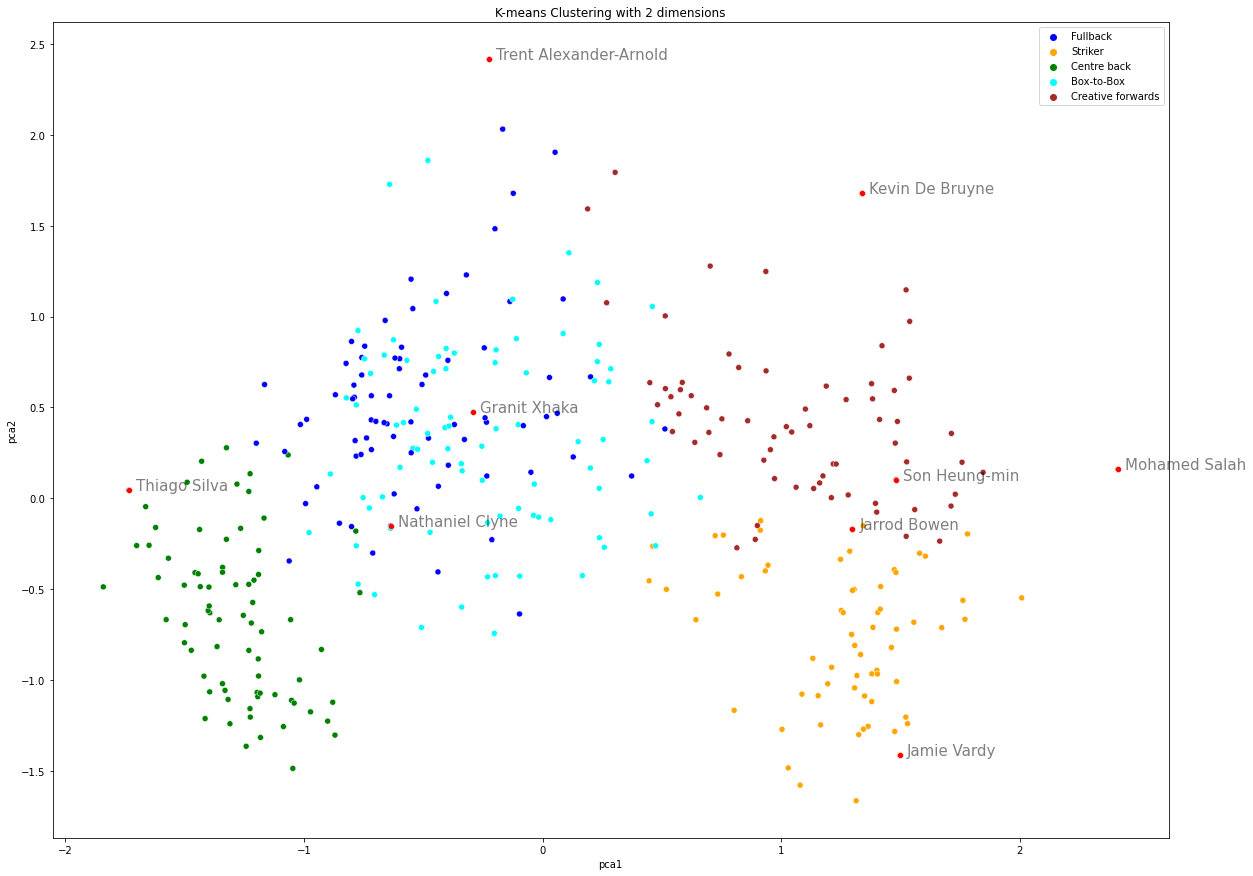

In [14]:
# Principle Component Analysis used to reduce dimensionality to 2 so I could show the clusters visually
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(trimmed_data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])


f,ax = plt.subplots(figsize=(20,15))
sns.scatterplot(x="pca1", y="pca2", hue=y_hue, data=results, palette=['blue','orange','green','cyan','brown'])
plt.title('K-means Clustering with 2 dimensions')

#Some key players to be plotted to show an idea of the data
key_players = ['Trent Alexander-Arnold', 'Jarrod Bowen', 'Nathaniel Clyne', 'Kevin De Bruyne', 'Son Heung-min', 'Mohamed Salah', 'Thiago Silva', 'Jamie Vardy', 'Granit Xhaka']
key_players_rows = reduced_data[prem_data['Player'].isin(key_players)]
key_players_co = pd.DataFrame(key_players_rows,columns=['pca1','pca2'])
sns.scatterplot(x='pca1', y='pca2', data=key_players_co, color='red')

for i in range(len(key_players)):
    plt.annotate(key_players[i], (key_players_rows[i][0]+0.03,key_players_rows[i][1]), fontsize=15, fontfamily='sans', alpha=0.5)

plt.show()

In [15]:
#pd.set_option('display.max_rows', None)
#prem_data[y==2]['Player']

In [16]:
#Preparing non-premier league dataset 
df = df[df["Pos"]!='GK']
other_players_og = df[df['Comp']!='Premier League']
other_players = other_players_og.drop(['ï»¿Rk','Player','Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s'],axis=1)
other_players = other_players.drop(to_drop,axis=1)

# Pick a player and see how close they are classified!
def PredictPosition(player_name):
    player_name = [player_name]
    player = other_players[df['Player']==player_name[0]]
    player = model.transform(player)
    return(mapping[kmeans.predict(player)[0]])

# Plot the player with all the premier league player clusters
def PlotPlayers(player_name):
    player_name = [player_name]
    f,ax = plt.subplots(figsize=(20,15))
    sns.scatterplot(x="pca1", y="pca2", hue=y_hue, data=results, palette=['blue','orange','green','cyan','brown'])
    plt.title('K-means Clustering with 2 dimensions')
    for i in range(len(key_players)):
        plt.annotate(key_players[i], (key_players_rows[i][0]+0.03,key_players_rows[i][1]), fontsize=15, fontfamily='sans', alpha=0.5)


    reduced_players = PCA(n_components=pca_num_components).fit_transform(model.transform(other_players))
    player_row = reduced_players[other_players_og['Player'].isin(player_name)]
    player_co = pd.DataFrame(player_row,columns=['pca1','pca2'])
    sns.scatterplot(x='pca1', y='pca2', data=player_co, color='red')
    plt.annotate(player_name[0], (player_row[0][0]+0.03,player_row[0][1]), fontsize=15, fontfamily='sans', color='red', alpha=0.9)
    plt.show()


In [17]:
#knn with pos instead of new clusters?

In [18]:
# Simple knn to find 5 nearest players to any inputted player
def NearestPlayers(player_name):
    player_name = [player_name]
    player = other_players[df['Player']==player_name[0]]
    player = model.transform(player)
    knn = NearestNeighbors(n_neighbors = 5)
    knn.fit(trimmed_data)
    similar_players = []
    for index in knn.kneighbors(player, n_neighbors=5)[1].flatten():
        similar_players.append(prem_data.iloc[index]['Player'])
    return similar_players

In [19]:
# Gives full player description based off prediction algorithm
def PlayerDescription(player_name):
    print('\033[1m' + player_name + '\033[0m')
    print()
    print('Position: ' + PredictPosition(player_name))
    print()
    print('Similar Premier League Players:\n')
    for i in range(5): print(NearestPlayers(player_name)[i])
    PlotPlayers(player_name)

Erling Haaland

Position: Striker

Similar Premier League Players:

Harry Kane
Cristiano Ronaldo
Mohamed Salah
Jamie Vardy
Ivan Toney


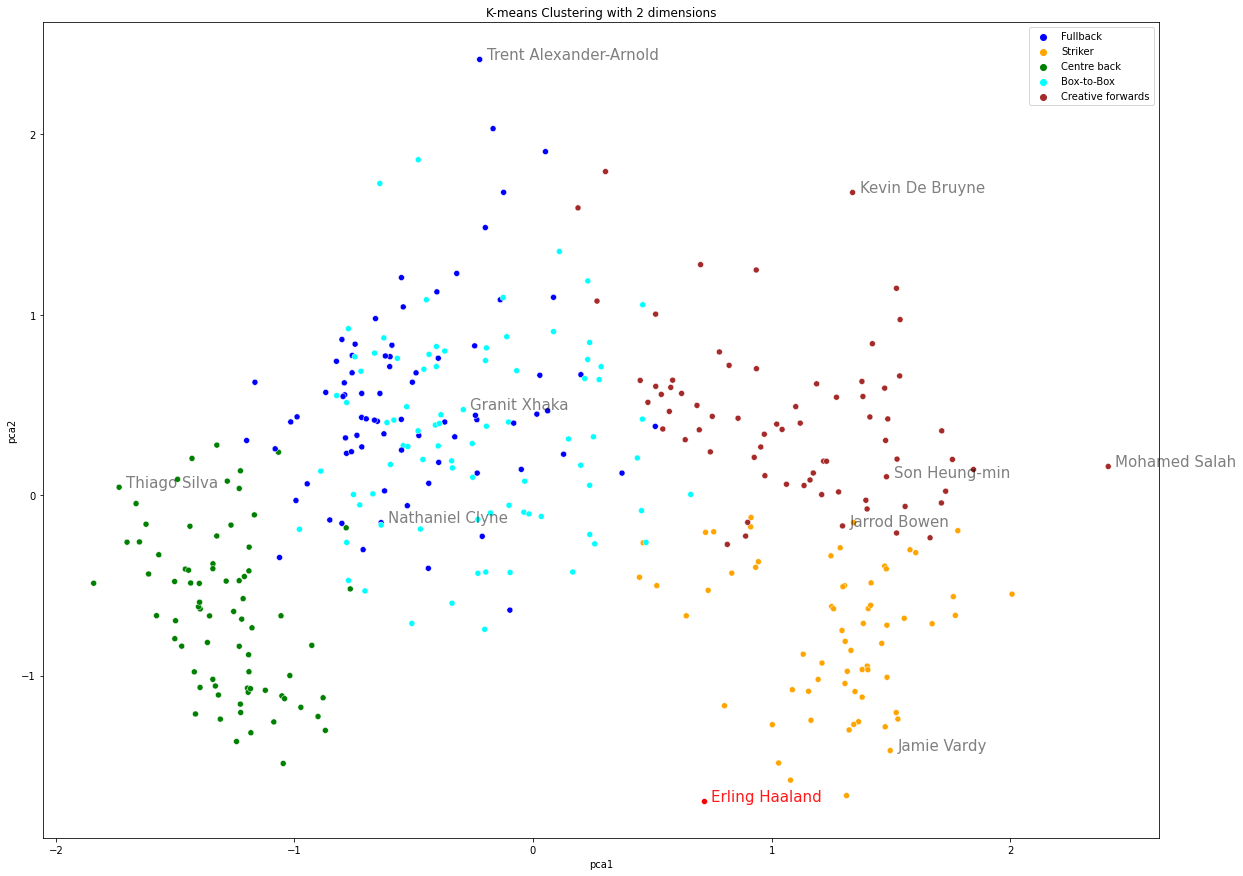

In [20]:
# Enter a name in the parentheses to see the players description!
PlayerDescription('Erling Haaland')

In [21]:
'''
Interesting Points:
- Can see the most extreme statiscal players quite clearly (Salah, De Bruyne, TAA)
- Fullbacks and midfielders are statiscally very similar (makes sense)
- The knn can somehow distinguish between these positions very well despite how close they look visually 
 (maybe need to research how it is doing that)
- There are clear clusters otherwise

Ideas:
- New Players are predicted very accurately (could maybe do a test with actual positions on df to see how accurate?)
- Try with more clusters to get more positions?
'''

'\nInteresting Points:\n- Can see the most extreme statiscal players quite clearly (Salah, De Bruyne, TAA)\n- Fullbacks and midfielders are statiscally very similar (makes sense)\n- The knn can somehow distinguish between these positions very well despite how close they look visually \n (maybe need to research how it is doing that)\n- There are clear clusters otherwise\n\nIdeas:\n- New Players are predicted very accurately (could maybe do a test with actual positions on df to see how accurate?)\n- Try with more clusters to get more positions?\n'